## Objective - To build a model for predicting whether a customer is happy or not

Importing relevant libraries

In [1]:
import os
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance        # Feature importance
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import random
from lazypredict.Supervised import LazyClassifier
from sklearn import datasets
from sklearn.utils.testing import ignore_warnings

C:\Users\Anant Gupta\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


Change directory and import the data set

In [8]:
os.chdir("F:\Blue Sky\EVERYTHING\DATA SCIENCE\Apziva\Happy Customers")
hc = pd.read_csv("ACME-HappinessSurvey2020.csv")
hc.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


Renaming columns for increasing readability

In [9]:
hc.columns = ['happiness_status', 'timely_delivery', 'exp_contents', 'ordered_all', 'good_price', 'courier_satisf', 'easy_app_order']
hc.head()

,happiness_status,timely_delivery,exp_contents,ordered_all,good_price,courier_satisf,easy_app_order
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


### Exploratory Data Analysis

In [10]:
hc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   happiness_status  126 non-null    int64
 1   timely_delivery   126 non-null    int64
 2   exp_contents      126 non-null    int64
 3   ordered_all       126 non-null    int64
 4   good_price        126 non-null    int64
 5   courier_satisf    126 non-null    int64
 6   easy_app_order    126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [11]:
hc.describe()

,happiness_status,timely_delivery,exp_contents,ordered_all,good_price,courier_satisf,easy_app_order
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00


No null or missing values. No imputation required

Check class balancing to identify if oversampling or undersampling is required

In [12]:
hc['happiness_status'].value_counts()

1    69
0    57
Name: happiness_status, dtype: int64

The class of the independent variable is balanced as 53% of the values belong to one class and 47% to another class. Oversampling or undersampling is not required

Set seed for reproducability

In [13]:
seed_value = 42
random.seed(seed_value)

Train Test split - For training and testing data

In [14]:
X = hc.drop(columns = 'happiness_status')
y = hc['happiness_status']
print(X.head())
print(y.head())

   timely_delivery  exp_contents  ordered_all  good_price  courier_satisf  \
0                3             3            3           4               2   
1                3             2            3           5               4   
2                5             3            3           3               3   
3                5             4            3           3               3   
4                5             4            3           3               3   

   easy_app_order  
0               4  
1               3  
2               5  
3               5  
4               5  
0    0
1    0
2    1
3    0
4    0
Name: happiness_status, dtype: int64


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
print(X_train.head())
print(X_train.shape)
print(X_test.shape)

     timely_delivery  exp_contents  ordered_all  good_price  courier_satisf  \
116                3             4            4           5               1   
13                 4             2            4           5               4   
33                 3             2            4           4               4   
75                 3             2            3           3               4   
26                 3             3            3           5               5   

     easy_app_order  
116               3  
13                3  
33                5  
75                4  
26                5  
(100, 6)
(26, 6)


## Modeling

Creating different classification models to train them on training data and testing accuracy. We'll start with basic models like Logistic Regression and then move on to complex models like Random Forest.The idea is to get best possible F1-score accuracy and hence identify best model.

## 1. Logistic Regression

1a. Creating Logistic Regression model using Statsmodels module to identify statistical significance of features 

In [16]:
X_sm = X                          # Creating a copy of X because we'll be adding a constant for Statsmodels logistic regression
X_sm = sm.add_constant(X_sm)      # Adding constant y-intercept for training data
logit_model = sm.Logit(y,X_sm)    # Building the model (An instance og Logistic Regression)
result = logit_model.fit()        # Fitting the data
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.637875
         Iterations 5
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.074   
Dependent Variable: happiness_status AIC:              174.7445
Date:               2021-06-08 16:38 BIC:              194.5985
No. Observations:   126              Log-Likelihood:   -80.372 
Df Model:           6                LL-Null:          -86.764 
Df Residuals:       119              LLR p-value:      0.046597
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
const           -3.5674   1.4891 -2.3957 0.0166 -6.4859 -0.6489
timely_delivery  0.5738   0.2888  1.9866 0.0470  0.0077  1.1400
exp_contents    -0.0937   0

timely_delivery is the most statistically significant variable and good_price is least statistically significant variable

1b. Creating Logistic Regression model using sklearn module to calculate F1-score

In [17]:
logreg = LogisticRegression()    # Building model as an instance of Logistic Regression
logreg.fit(X_train, y_train)     # Fitting training data
y_pred_logit = logreg.predict(X_test)  # Predict based on test data

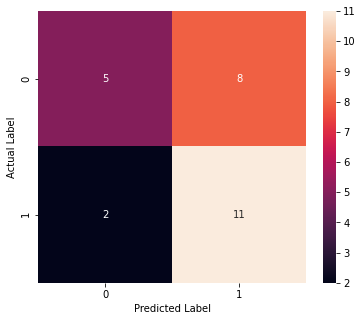

In [18]:
confusion_matrix = confusion_matrix(y_test, y_pred_logit)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (6,5))
sn.heatmap(df_cm, annot = True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.58      0.85      0.69        13

    accuracy                           0.62        26
   macro avg       0.65      0.62      0.59        26
weighted avg       0.65      0.62      0.59        26



F1-score accuracy with Logistic Regression is 62%

# 2. K Nearest Neighbors

K Nearest Neighbors is another popular classification alogorithm. It looks at "K" neighbors and classifies the test data point based on majority.

In [20]:
k_range = range(1,100)                               # Range of k for experimentation
scores = {}                                          # Empty dictionary for storing scores for each value of k
score_list = []                                      # Empty list for storing scores
for k in k_range:                                    # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)      # Build an instance of KNeighborsClassifier Model
    knn.fit(X_train, y_train)                        # Fit the model with training data
    y_pred_knn = knn.predict(X_test)                 # Make predictions for test data
    scores[k] = f1_score(y_test, y_pred_knn)         # Generate F1 score and append to scores dictionary with respective k value
    score_list.append(f1_score(y_test, y_pred_knn))  # Append F1 score to score_list dictionary

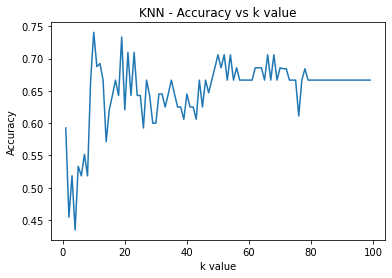

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [22]:
# Get maximum score
max(score_list)

0.7407407407407408

In [23]:
# Get K value for maximum score
max(scores, key=scores.get)

10

Maximum F1 score accuracy occurs at K=10

### Final KNN model

In [24]:
knn_f = KNeighborsClassifier(n_neighbors = 10)     # Build an instance of KNeighborsClassifier Model with k=10
knn_f.fit(X_train, y_train)                        # Fit the model with training data
y_pred_knn_f = knn_f.predict(X_test)               # Make predictions for test data

In [25]:
print(classification_report(y_test, y_pred_knn_f))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



Maximum F1 score accuracy with K Nearest Neighbors is 73% and it occurs at K=10

# 3. Decision Tree

Decison tree is another classification model which classifies data into categories based on certain tests

In [26]:
dtc = DecisionTreeClassifier(random_state = 0)      # Create an instance of DecisionTreeClassifier
dtc.fit(X_train, y_train)                           # Fit the model with training data
y_pred_dtc = dtc.predict(X_test)                    # Make predictions for test data

In [27]:
y_pred_dtc                                          # Checking predictions

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1], dtype=int64)

In [28]:
print(classification_report(y_test, y_pred_dtc))    # Get classification report

              precision    recall  f1-score   support

           0       0.50      0.54      0.52        13
           1       0.50      0.46      0.48        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.50        26
weighted avg       0.50      0.50      0.50        26



F1 score accuracy with Decision Tree Model is 50%

Cross Validation - For understanding accuracy when data is split differently for training and testing

In [29]:
cross_val_score(dtc, X_train, y_train, cv = 10)

array([0.7, 0.7, 0.5, 0.6, 0.8, 0.5, 0.6, 0.6, 0.8, 0.4])

There's a big variation in the accuracy (from 0.4 to 0.8) which suggests that data is not homogeneous possibly due to low number of data points

# 4. Random Forest

Random forest is a popular ensemble model. It is an ensemble of multiple decision trees

In [30]:
rf = RandomForestClassifier(random_state = 0)    # Create an instance of RandomForestClassifier
rf.fit(X_train, y_train)                         # Fit the model with training and test data
y_pred_rf = rf.predict(X_test)                   # Make predictions on the test data

In [31]:
print(classification_report(y_test, y_pred_rf))  # Generate classification report

              precision    recall  f1-score   support

           0       0.56      0.38      0.45        13
           1       0.53      0.69      0.60        13

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.53        26
weighted avg       0.54      0.54      0.53        26



The F1 score accuracy for Random Forest improved slightly to 54% compared to 50% for Decision Tree model

# 5. Gradient Boosting

In [32]:
gb = GradientBoostingClassifier(random_state = 0)         # Create an instance of GradientBoostingClassifier
gb.fit(X_train, y_train)                                  # Fit the model
y_pred_gb = gb.predict(X_test)                            # Make predictions on the test data

In [33]:
print(classification_report(y_test, y_pred_gb))           # Generate classification report

              precision    recall  f1-score   support

           0       0.50      0.38      0.43        13
           1       0.50      0.62      0.55        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.49        26
weighted avg       0.50      0.50      0.49        26



F1 score accuracy with Gradient Boosting model is 50%

Based on the analysis so far, the range of F1 score accuracy is [50%, 73%] for different models. KNN model gives us the best F1 score accuracy of 73% at k=10

# Feature Importance

Not all features contribute equally in getting the F1-score accuracy. There will be some features which are most important and some which can be eliminated. The following exercise will help us understand feature importance of our 6 independent variables and thereby build a robust model.

Hypothesis - Based on our Logistic Regression analysis, timely_delivery should be the most important feature

### 1. Random Forest feature importance - It is based on Gini importance. Gini importance looks at highest average decrease in 'impurity' to identify important features

In [34]:
rf.feature_importances_      # Get Feature importances

array([0.17070373, 0.16632131, 0.18128957, 0.14844633, 0.17471919,
       0.15851988])

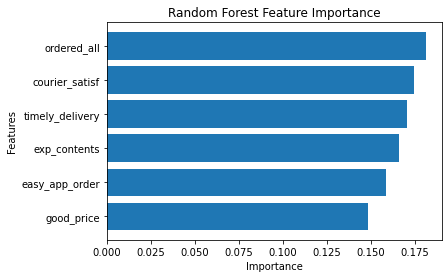

In [35]:
sorted_idx = rf.feature_importances_.argsort()                              # Sorting variables based on importance
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])        # Plot bar graph for feature importance
plt.title('Random Forest Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

All features seem to be almost equally important based on Random Forest feature importance. Ordered_all, courier_satif, timely_delivery, exp_contents are the 4 most important variables.

Moreover, Random forest feature importance has certain known drawbacks including its tendency to prefer variables with high cardinality (high number of possible values). Also, in the case of correlated variables, it selects one variable and ignores the other variables.

### 2. Permuation Importance - This method randomly shuffles features and computes change in model performance and is model agnostic. It also overcomes drawbacks of Random Forest feature importance.

Since this method is model agnostic, let's experiment with different models

### 2a. Logistic Regression

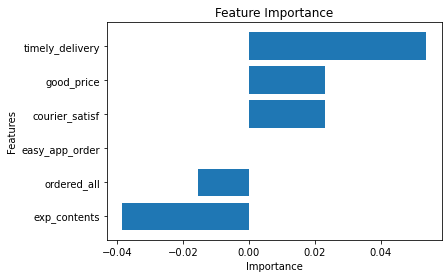

In [36]:
perm_importance = permutation_importance(logreg, X_test, y_test)                 # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### 2b. K Nearest Neighbors

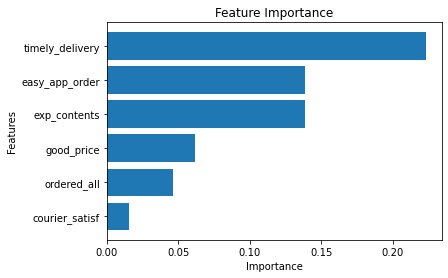

In [37]:
perm_importance = permutation_importance(knn_f, X_test, y_test)                  # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### 2c. Decision Tree

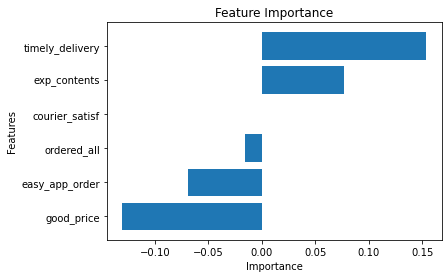

In [38]:
perm_importance = permutation_importance(dtc, X_test, y_test)                  # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### 2d. Random Forest

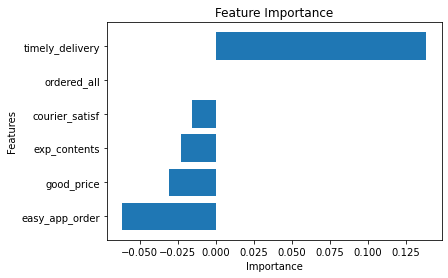

In [39]:
perm_importance = permutation_importance(rf, X_test, y_test)                  # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

### 2e. Gradient Boosting

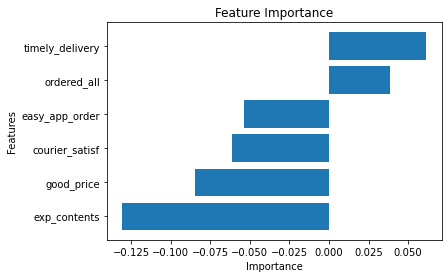

In [40]:
perm_importance = permutation_importance(gb, X_test, y_test)                  # Get feature importance
sorted_idx = perm_importance.importances_mean.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])    # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

Based on the above 5 plots, timey_delivery is clearly the most important variable. For other variables, all models give different results. Since KNN has the highest F1 score accuracy, we can go ahead with the results of KNN Permuation Feature importance.

The most important variables in order are timely_delivery, exp_contents, courier_satisf and good_price

### Building KNN model with 4 important variables

In [41]:
X_new = X[['timely_delivery', 'exp_contents', 'courier_satisf', 'good_price',]]

In [42]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size = 0.2, random_state = 0)
print(X_train_new.head())
print(X_train_new.shape)
print(X_test_new.shape)

     timely_delivery  exp_contents  courier_satisf  good_price
116                3             4               1           5
13                 4             2               4           5
33                 3             2               4           4
75                 3             2               4           3
26                 3             3               5           5
(100, 4)
(26, 4)


In [43]:
k_range = range(1,100)                                       # Range of k for experimentation
scores_new = {}                                              # Empty dictionary for storing scores for each value of k
score_list_new = []                                          # Empty list for storing scores
for k in k_range:                                            # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)              # Build an instance of KNeighborsClassifier Model
    knn.fit(X_train_new, y_train_new)                        # Fit the model with training data
    y_pred_knn = knn.predict(X_test_new)                     # Make predictions for test data
    scores_new[k] = f1_score(y_test_new, y_pred_knn)         # Generate F1 score and append to scores dictionary with respective k value
    score_list_new.append(f1_score(y_test_new, y_pred_knn))  # Append F1 score to score_list dictionary

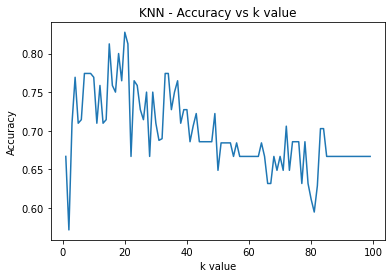

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_new)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [45]:
# Get maximum score
max(score_list_new)

0.8275862068965517

In [46]:
# Get K value for maximum score
max(scores_new, key=scores_new.get)

20

Maximum F1 score accuracy occurs at K = 20

### Final KNN Model

In [47]:
knn_f_new = KNeighborsClassifier(n_neighbors = 20)             # Build an instance of KNeighborsClassifier Model with k=10
knn_f_new.fit(X_train_new, y_train_new)                        # Fit the model with training data
y_pred_knn_f_new = knn_f_new.predict(X_test_new)               # Make predictions for test data

In [48]:
print(classification_report(y_test_new, y_pred_knn_f_new))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.75      0.92      0.83        13

    accuracy                           0.81        26
   macro avg       0.82      0.81      0.81        26
weighted avg       0.83      0.81      0.81        26



Maximum KNN F1 score accuracy using only 4 important variables comes out to 81% when k = 20

Removing 2 least important features led to a 8% increase in F1 score accuracy in the KNN model. Since it is a significant increase in accuracy, it is in our best interest to use the KNN model with 4 important independent variables.

# Recursive Feature Elimination (RFECV)

Recursive Feature Elimination is a popular technique to iterately remove less important variables and finally arrive at an optimal model with few important features

In [49]:
rfecv = RFECV(estimator = rf, step = 1, cv = StratifiedKFold(10), scoring = 'f1_macro')  # Creating an instance of RFECV usin Random Forest as estimator
rfecv.fit(X,y)                                                                           # Fitting data into rfecv

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=0), scoring='f1_macro')

In [50]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 4


Optimal number of features for RFECV with Random Forest as estimator is 4

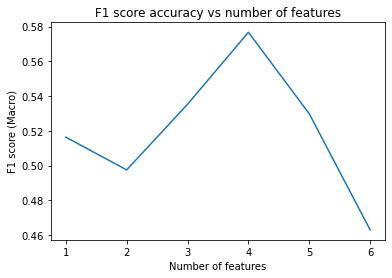

In [51]:
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.title("F1 score accuracy vs number of features")
plt.xlabel('Number of features')
plt.ylabel("F1 score (Macro)")
plt.show()

In [52]:
max(rfecv.grid_scores_)

0.5767478354978357

Maximum F1 score accuracy is 57.67% when number of features is 4

In [53]:
rfecv.estimator.feature_importances_

array([0.17070373, 0.16632131, 0.18128957, 0.14844633, 0.17471919,
       0.15851988])

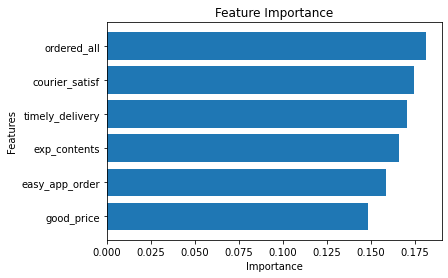

In [54]:
sorted_idx = rfecv.estimator.feature_importances_.argsort()                          # Order features based on importance
plt.barh(X.columns[sorted_idx], rfecv.estimator.feature_importances_[sorted_idx])   # Plot bar graph
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.show()

Ordered_all, courier_satif, timely_delivery, exp_contents are the 4 most important variables according to RFECV. This is the exact same result compared to Random Forest feature importance.

# Oversampling and Undersampling

There is a minor imbalance in our training dataset (1 - 56 datapoints, 0 - 44 datapoints). Let's try oversampling and undersampling techniques to balance our dataset and see whether it increases our F1 score accuracy.

In [55]:
# Current classfication distribution in training dataset
Counter(y_train)

Counter({1: 56, 0: 44})

Lets start with Oversampling first. We'll create synthetic observations only for the training dataset and not the test dataset. This will keep our test dataset pure and without synthetic samples.

In [56]:
ros = RandomOverSampler()                               # Create and instance of RandomOverSampler
X_ros, y_ros = ros.fit_resample(X_train, y_train)       # Resample training data
Counter(y_ros)                                          # Class distribution after oversampling

Counter({1: 56, 0: 56})

Both classes are now balanced as each class has 56 datapoints

### Building KNN model with oversampled training data

In [57]:
k_range = range(1,100)                                     # Range of k for experimentation
scores_os = {}                                             # Empty dictionary for storing scores for each value of k
score_list_os = []                                         # Empty list for storing scores
for k in k_range:                                          # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)            # Build an instance of KNeighborsClassifier Model
    knn.fit(X_ros, y_ros)                                  # Fit the model with training data
    y_pred_knn_os = knn.predict(X_test)                    # Make predictions for test data
    scores_os[k] = f1_score(y_test, y_pred_knn_os)         # Generate F1 score and append to scores dictionary with respective k value
    score_list_os.append(f1_score(y_test, y_pred_knn_os))  # Append F1 score to score_list_os dictionary

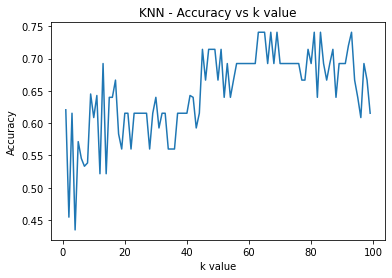

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_os)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [59]:
# Get maximum score
max(score_list_os)

0.7407407407407408

In [60]:
# Get K value for maximum score
max(scores_os, key=scores_os.get)

63

Oversampling increases maximum F1 score accuracy marginally with KNN model for test dataset but it is significantly lower than 81% F1 score accuracy achieved using 4 important variables. 

Let's now see whether undersampling increases accuracy.

In [61]:
rus = RandomUnderSampler()                               # Create and instance of RandomUnderSampler
X_rus, y_rus = rus.fit_resample(X_train, y_train)        # Resample training data
Counter(y_rus)                                           # Class distribution after undersampling

Counter({0: 44, 1: 44})

Both classes are now balanced as each class has 44 datapoints

### Building KNN model with undersampled training data

In [62]:
k_range = range(1,80)                                     # Range of k for experimentation
scores_us = {}                                             # Empty dictionary for storing scores for each value of k
score_list_us = []                                         # Empty list for storing scores
for k in k_range:                                          # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)            # Build an instance of KNeighborsClassifier Model
    knn.fit(X_rus, y_rus)                                  # Fit the model with training data
    y_pred_knn_us = knn.predict(X_test)                    # Make predictions for test data
    scores_us[k] = f1_score(y_test, y_pred_knn_us)         # Generate F1 score and append to scores dictionary with respective k value
    score_list_us.append(f1_score(y_test, y_pred_knn_us))  # Append F1 score to score_list_us dictionary

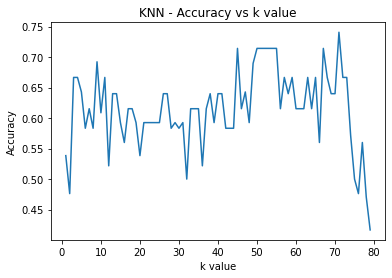

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_us)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [64]:
# Get maximum score
max(score_list_us)

0.7407407407407408

In [65]:
# Get K value for maximum score
max(scores_us, key=scores_us.get)

71

Maximum F1 score accuracy with undersampled model occurs at K = 54

### Building final KNN model with undersampled training data and K = 54

In [66]:
knn_f_us = KNeighborsClassifier(n_neighbors = 54)     # Build an instance of KNeighborsClassifier Model with k=10
knn_f_us.fit(X_rus, y_rus)                            # Fit the model with training data
y_pred_knn_f_us = knn_f_us.predict(X_test)            # Make predictions for test data

In [67]:
print(classification_report(y_test, y_pred_knn_f_us))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.67      0.77      0.71        13

    accuracy                           0.69        26
   macro avg       0.70      0.69      0.69        26
weighted avg       0.70      0.69      0.69        26



Undersampled KNN model increases F1 score accuracy significantly to 77% but it is still lower than 81% F1 score accuracy using 4 important variables

## KNN model with undersampling and feature importance

Based on the analysis so far, we noticed that our F1 score accuracy increased due to 2 reasons
1. Choosing important variables using feature importance
2. Undersampling

Lets try to build a model with a combination of both these things

In [68]:
rus_new = RandomUnderSampler()                                               # Create and instance of RandomUnderSampler
X_rus_new, y_rus_new = rus_new.fit_resample(X_train_new, y_train_new)        # Resample training data
Counter(y_rus)  

Counter({0: 44, 1: 44})

Both classes are now balanced as each class has 44 datapoints

### Building KNN model with undersampled training data and 4 important variables

In [69]:
k_range = range(1,80)                                                  # Range of k for experimentation
scores_us_new = {}                                                     # Empty dictionary for storing scores for each value of k
score_list_us_new = []                                                 # Empty list for storing scores
for k in k_range:                                                      # Loop over k
    knn = KNeighborsClassifier(n_neighbors = k)                        # Build an instance of KNeighborsClassifier Model
    knn.fit(X_rus_new, y_rus_new)                                      # Fit the model with training data
    y_pred_knn_us_new = knn.predict(X_test_new)                        # Make predictions for test data
    scores_us_new[k] = f1_score(y_test_new, y_pred_knn_us_new)         # Generate F1 score and append to scores dictionary with respective k value
    score_list_us_new.append(f1_score(y_test_new, y_pred_knn_us_new))  # Append F1 score to score_list_us dictionary

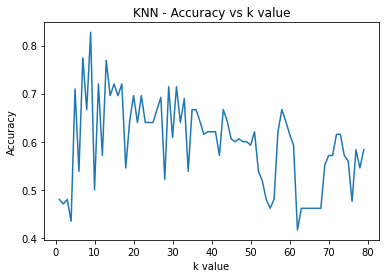

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_us_new)                   # Plot Accuracy vs k value
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [71]:
# Get maximum score
max(score_list_us_new)

0.8275862068965517

In [72]:
# Get K value for maximum score
max(scores_us_new, key=scores_us_new.get)

9

Maximum F1 score accuracy remains in mid-seventies which is significantly lower than 81% F1 score accuracy achieved by KNN model with 4 important variables.

# Lazy Predict

LazyPredict is a Python library which analyzes a bunch of models with few lines of codes. Once we have a bunch of models and their F1 scores, we can run top 3 models and analyze the cross validation score.

In [81]:
lzy = LazyClassifier(predictions = True)                              # Create an instance of LazyClassifier
models, predictions = lzy.fit(X_train, X_test, y_train, y_test)       # Fit train and test data
models                                                                # Generate results for various models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.64it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.73,0.73,0.73,0.71,0.00
PassiveAggressiveClassifier,0.69,0.69,0.69,0.69,0.01
NearestCentroid,0.69,0.69,0.69,0.69,0.02
LGBMClassifier,0.65,0.65,0.65,0.65,0.07
BernoulliNB,0.62,0.62,0.62,0.61,0.01
SGDClassifier,0.62,0.62,0.62,0.62,0.01
GaussianNB,0.62,0.62,0.62,0.61,0.01
LogisticRegression,0.62,0.62,0.62,0.59,0.02
LinearDiscriminantAnalysis,0.58,0.58,0.58,0.54,0.01


Perceptron, PassiveAggressiveClassifier and NearestCentroid have the highest F1 score accuracy among all the models.

### 1. Perceptron

In [2]:
n_iter = 40
eta0 = 0.1
ppn = Perceptron(n_iter = n_iter, eta0=eta0, random_state = 0)

TypeError: __init__() got an unexpected keyword argument 'n_iter'

# Summary

1. Highest F1 score accuracy achieved is 73% using KNN algorithm when k=10 with all 6 features.

2. Undersampling keeps the F1 score accuracy at 73% using KNN alogorithm when k=54 with all 6 features. Oversampling decreased the accuracy slightly probably due to overfitting of training data.

3. Highest F1 score accuracy achieved is 65% using KNN alogrithm when k=33 with 4 important variables (timely_delivery, exp_contents, good_price, easy_app_order) selected using Permutation feature importance.

4. Highest F1 score (macro) accuracy achieved is 57.67% using Recursive Feature Elimination and Random Forest as estimator. The optimal number of features is 4 and are as follows: ordered_all, courier_satif, timely_delivery and exp_contents.